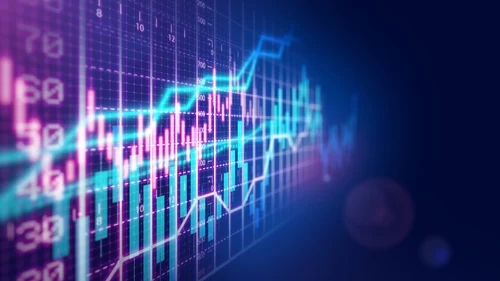

# Introduction
#### In this notebook the aim is to predict Google stock prices by using LSTM

## Content
* [Read Data](#1)
* [Preproccesing](#2)
* [LSTM Model](#3)
* [Predictions and Visualization](#4)

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

<a id="1"></a>
## Read Data

In [ ]:
train_data = pd.read_csv("/kaggle/input/googledta/trainset.csv")

In [ ]:
train_data.head()

In [ ]:
train_data.describe()

In [ ]:
train_data.info()

#### In this plot we are able to see whole data.

In [ ]:
from plotly.subplots import make_subplots

# Create subplots and mention plot grid size
fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
               vertical_spacing=0.08, subplot_titles=('GOOGL', 'Volume'), 
               row_width=[0.2, 0.7])

# Plot data 
fig.add_trace(go.Candlestick(x=train_data["Date"], open=train_data["Open"], high=train_data["High"],
                low=train_data["Low"], close=train_data["Close"], name="GOOGL"), 
                row=1, col=1)

fig.update_layout(
    title="Google Stock",
    yaxis_title="GOOGL Stock Price")

# Plot volume
fig.add_trace(go.Bar(x=train_data['Date'], y=train_data['Volume'], showlegend=False), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

<a id="2"></a>
## Preproccesing

In [ ]:
train = train_data.loc[:, ["Open"]].values
train

In [ ]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0, 1)) # Converts between 0 and 1
train_scaled = scaler.fit_transform(train)
train_scaled

In [ ]:
plt.plot(train_scaled)
plt.ylabel("Price")
plt.xlabel("Time(Days)")
plt.title("Google Stock Data")
plt.show()

In [ ]:
# Creating a data structure with 50 timesteps and 1 output
X_train = []
y_train = []
timesteps = 1
for i in range(timesteps, 1258): #1258: len of days
    X_train.append(train_scaled[i-timesteps:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train

In [ ]:
y_train

In [ ]:
print(f"Shape of X_train: {X_train.shape}\nShape of y_train: {y_train.shape}")

<a id="3"></a>
## LSTM Model

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers.recurrent import LSTM

# Initialize
model = Sequential()

# Firs LSTM layer and Regularization with Dropout
model.add(LSTM(128, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compile
model.compile(loss="mean_squared_error", optimizer="adam")
model.fit(X_train, y_train.reshape(-1,1), epochs=100)

<a id="4"></a>
## Predictions and Visualization

In [ ]:
test_data = pd.read_csv('/kaggle/input/googledta/testset.csv')
test_data.head()

In [ ]:
real_stock_price = test_data.loc[:, ["Open"]].values
real_stock_price

In [ ]:
dataset_total = pd.concat((train_data['Open'], test_data['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_data) - timesteps:].values.reshape(-1,1)
inputs = scaler.transform(inputs)  # min max scaler
inputs

In [ ]:
X_test = []
for i in range(timesteps, 127):
    X_test.append(inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

# Visualising the results
plt.figure(figsize=(12,9))
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue',alpha=0.7, label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time(Days)')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()